In [178]:
using PyCall
using Distances
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using PyPlot
using SparseArrays
using Printf

In [179]:
py"""
import numpy as np
import cv2

class RootSIFT:
    def __init__(self):
        self.extractor = cv2.xfeatures2d.SIFT_create()

    def compute(self, image, kps, eps=1e-7):
        (kps, descs) = self.extractor.compute(image, kps)
        if len(kps) == 0:
            return ([], None)

        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        return (kps, descs)
def rootSIFT(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    (kps, descs) = sift.detectAndCompute(gray, None)
    rs = RootSIFT()
    (kps, descs) = rs.compute(gray, kps)
    pos = [np.array([x.pt[0], x.pt[1]]) for x in kps]
    return np.array(pos)

"""

img1_path = "../data/test/test_1.jpg"
img2_path = "../data/test/test_2.jpg"

descs1 = py"rootSIFT"(img1_path);
descs2 = py"rootSIFT"(img2_path);

In [180]:
function cleaning(original)
    res_dict = Dict()
    for i in 1:size(original, 1)
        res_dict[hash(original[i,:])] = original[i,:]
    end
    
    vals = collect(values(res_dict))
    output = zeros(size(vals,1), 2)
    for i in 1:size(vals,1)
        output[i,:] = [vals[i][1],vals[i][2]]
    end
    
    return output
end

cleaning (generic function with 1 method)

In [181]:
P_points = cleaning(descs1);
Q_points = cleaning(descs2);

In [182]:
cost = pairwise(Euclidean(), P_points, Q_points; dims=1)

29×30 Array{Float64,2}:
 33.1816  25.6977   12.5919   64.3669   …  38.8252   12.1565   17.7326 
 17.109   24.5156   41.144    51.0615      26.5338   39.2535   13.9303 
 23.0895  29.6556   42.2538   56.9207      32.5173   40.8556   17.3149 
 41.6943  33.7886   10.4469   72.4677      47.1976   12.6395   26.1198 
 35.3427  41.8389   72.8359    8.66254     28.1991   69.1836   51.3037 
 26.9523  14.1883   28.062    42.5566   …  24.4311   24.2601   25.8473 
 18.4356  26.6515   57.8012   18.1954      12.5528   54.3216   34.5311 
 19.1683  19.522    49.591    19.3089       9.77404  45.8599   31.9935 
 15.3118  17.7139   32.8203   50.1596      24.0252   30.705     5.13884
 31.4239  18.2475   20.8426   50.346       30.7491   17.1347   26.0223 
 25.8451  13.9655   17.4713   51.4418   …  28.0474   13.8194   16.8654 
 42.4462  33.7024    7.57679  72.2448      47.4102   10.2362   27.3188 
 32.3497  21.6362    9.57194  59.5758      35.7111    6.28212  19.984  
  ⋮                                     

In [183]:
P = ones(size(P_points,1));
Q = ones(size(Q_points,1));

In [184]:
solCount = 1000
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0,PoolGap = 0.001))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P), sum(Q)))
@constraint(m, X * ones(Int, length(Q)) .<= P)
@constraint(m, X'ones(Int, length(P)) .<= Q);
optimize!(m)
solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 60 rows, 870 columns and 2610 nonzeros
Variable types: 0 continuous, 870 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve time: 0.00s
Presolved: 60 rows, 870 columns, 2610 nonzeros
Variable types: 0 continuous, 870 integer (870 binary)

Root relaxation: objective 2.621752e+02, 92 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     262.1752216  262.17522  0.00%     -    0s
Optimal solution found at node 0 - now completing solution pool...
     0     0          -    0       262.17522  262.17522  0.00%     -    0s
     0     0          -    0       262.17522  262.17522  0.00%     -    0s
     0     2          -    0       262.17522  262.17522  0.00%     -    0s

Explored 1645

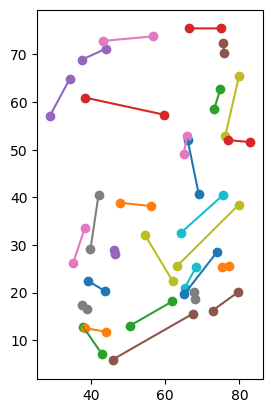

In [210]:
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    x_pos = [P_points'[:,x][1], Q_points'[:,y][1]]
    y_pos = [P_points'[:,x][2], Q_points'[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
    
end